In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

/tmp/ipykernel_6221/3190709933.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
import sys
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    %cd '/content/drive/MyDrive/Inteligencia Artificial/IA - Clases de Práctica/ContenidosPorTemas'
    print('google.colab')

In [3]:
np.random.seed(42)

# Cargamos los datos
df_housing = pd.read_csv("./1_datos/housing.csv")

# Creamos nuestro atributo categórico para los ingresos
df_housing["income_cat"] = pd.cut(df_housing["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])

# Dividimos los datos en conjunto de entrenamiento y prueba
strat_train_set, strat_test_set = train_test_split(df_housing, test_size=0.2, stratify=df_housing["income_cat"], random_state=42)

# Eliminamos la categoria income_cat de ambos conjuntos porque no la usamos
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

# Separamos predictores y etiquetas
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

# Prepación de los Datos usando transformers

implementar funciones para la transformación de los datos es muy útil.


In [4]:
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(housing[["population"]])


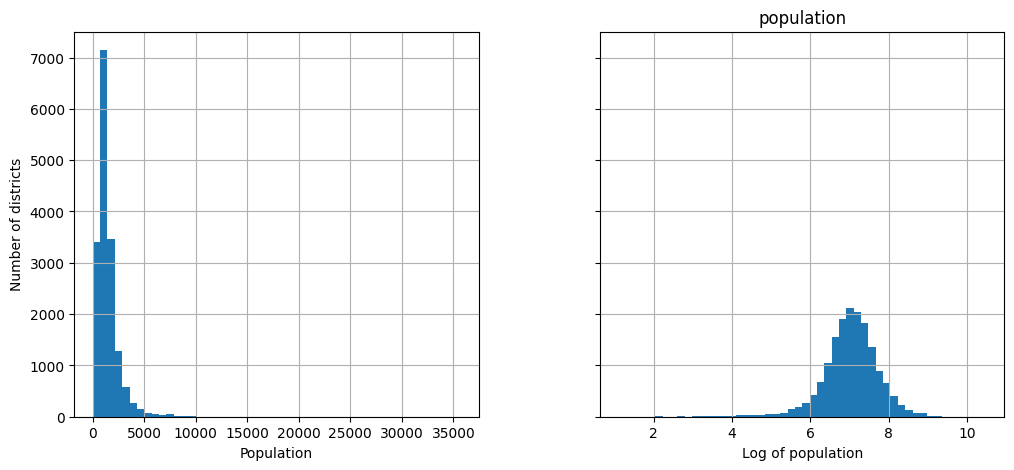

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

housing["population"].hist(ax=axs[0], bins=50)
log_pop.hist(ax=axs[1], bins=50)

axs[0].set_xlabel("Population")
axs[1].set_xlabel("Log of population")
axs[0].set_ylabel("Number of districts")

plt.show()

Pero ¿qué sucede si deseas que tu transformador sea entrenable, es decir, que aprenda algunos parámetros en el método `fit()` y los use más tarde en el método `transform()`? Para esto, necesitas escribir una clase personalizada. Scikit-Learn se basa en duck typing, por lo que esta clase no tiene que heredar de ninguna clase base en particular. Lo único que necesita son tres métodos: `fit()` (que debe devolver `self`), `transform()` y `fit_transform()`.

Se puede tener el método `fit_transform()` simplemente agregando `TransformerMixin` como una clase base: la implementación predeterminada simplemente llamará a `fit()` y luego a `transform()`. Si agregas `BaseEstimator` como una clase base, también obtendrás dos métodos adicionales: `get_params()` y `set_params()`. Estos serán útiles para ajustar hiperparámetros.

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class StandardScalerClone(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean=True):
        self.with_mean = with_mean

    def fit(self, X, y=None):  # y es requerido aunque no se usa
        X = check_array(X)  # verifica que X es un array con valores flotantes finitos
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0)
        self.n_features_in_ = X.shape[1]  # esta información se guarda en fit
        return self  # siempre debe retornar self!

    def transform(self, X):
        check_is_fitted(self)  # se fija en los atributos entrenados (con _ al final)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        if self.with_mean:
            X = X - self.mean_
        return X / self.scale_

## Pipelines

### Implementemos un pipeline para procesar los datos numéricos

In [7]:
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")), # los nombres deben ser únicos y no tener __ (dobles guiones bajos)
    ("standardize", StandardScaler()),
])
num_pipeline

Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                ('standardize', StandardScaler())])

Los componentes deben ser transformers (tener el método `fit_transform()`) excepto el último que debe tener el método `fit()`.

Cuando llamas al método `fit()` del pipeline, este llama secuencialmente a `fit_transform()` en todos los transformers, pasando la salida de cada llamada como parámetro a la siguiente llamada hasta llegar al estimador final, para el cual simplemente llama al método `fit()`.

El pipeline expone los mismos métodos que el estimador final. En este ejemplo, el último estimador es un `StandardScaler`, que es un transformer, por lo que el pipeline también actúa como un transformer. Si llamamos al método `transform()` del pipeline, aplicará secuencialmente todas las transformaciones a los datos.

Si el último estimador fuera un predictor en lugar de un transformador, entonces el pipeline tendrá un método `predict()` en lugar de `transform()`. Llamar a este método aplicaría secuencialmente todas las transformaciones a los datos y pasaría el resultado al método `predict()` del predictor.

In [8]:
housing_num = housing.drop("ocean_proximity", axis=1)

housing_num_prepared = num_pipeline.fit_transform(housing_num)
housing_num_prepared[:2].round(2)

array([[-0.94,  1.35,  0.03,  0.58,  0.64,  0.73,  0.56, -0.89],
       [ 1.17, -1.19, -1.72,  1.26,  0.78,  0.53,  0.72,  1.29]])

In [9]:
num_pipeline.get_feature_names_out()

array(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype=object)

In [10]:
df_housing_num_prepared = pd.DataFrame(
    housing_num_prepared, columns=num_pipeline.get_feature_names_out(),
    index=housing_num.index)
df_housing_num_prepared

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
12655,-0.941350,1.347438,0.027564,0.584777,0.640371,0.732602,0.556286,-0.893647
15502,1.171782,-1.192440,-1.722018,1.261467,0.781561,0.533612,0.721318,1.292168
2908,0.267581,-0.125972,1.220460,-0.469773,-0.545138,-0.674675,-0.524407,-0.525434
14053,1.221738,-1.351474,-0.370069,-0.348652,-0.036367,-0.467617,-0.037297,-0.865929
20496,0.437431,-0.635818,-0.131489,0.427179,0.272790,0.374060,0.220898,0.325752
...,...,...,...,...,...,...,...,...
15174,1.251711,-1.220505,-1.165333,1.890456,1.696862,0.543471,1.341519,0.637374
12661,-0.921368,1.342761,-1.085806,2.468471,2.161816,3.002174,2.451492,-0.557509
19263,-1.570794,1.310018,1.538566,-0.895802,-0.895679,-0.862013,-0.865118,-0.365475
19140,-1.560803,1.249211,-1.165333,0.249005,0.112126,-0.189747,0.010616,0.168261


### Mejor implementar un transformer que aplique las transformaciones necesarias a columnas numéricas y categóricas

In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms",
               "total_bedrooms", "population", "households", "median_income"]
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler()),
])

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])

Otra forma de escribir el transformer anterior sin listar todos los nombres de las columnas y sin nombrar los transformers

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer

num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler()),
])

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object)),
)

Ahora si, apliquemos nuestro transformer!!

In [ ]:
housing_prepared = preprocessing.fit_transform(housing)

In [ ]:
housing_prepared_df = pd.DataFrame(
    housing_prepared,
    columns=preprocessing.get_feature_names_out(),
    index=housing.index)

housing_prepared_df.head()

In [ ]:
housing_prepared_df.shape

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector

num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler()),
])

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))


log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())


preprocessing_2 = ColumnTransformer(
    [
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                               "households", "median_income"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
    ],
    remainder=num_pipeline

    )

In [ ]:
housing_prepared_2 = preprocessing_2.fit_transform(housing)

In [ ]:
housing_prepared_df_2 = pd.DataFrame(
    housing_prepared_2,
    columns=preprocessing_2.get_feature_names_out(),
    index=housing.index)

housing_prepared_df_2.head()

In [ ]:
housing_prepared_df_2[['log__population']].hist(bins=50)

plt.show()